# 1. setup configuration
## 1.1 Load Libraries

In [1]:
import re
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## 1.2 set variables

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
BATCH_SIZE = 8
IMAGE_SIZE = [180, 180]
EPOCHS = 25

# 2. Prepare Dataset
## 2.1 read file names

In [3]:
train_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
test_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/test/*/*'))
val_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*'))

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


## 2.2 split file names and count normal/pneumonia

In [4]:
filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
filenames.extend(tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*')))

train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)
print(len(train_filenames))
print(len(val_filenames))

COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal count in ts: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia count in ts: " + str(COUNT_PNEUMONIA))

4185
1047
Normal count in ts: 1091
Pneumonia count in ts: 3094


## 2.3 get datasets, counts, and class names

In [5]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training imgs count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("valid imgs count: " + str(VAL_IMG_COUNT))


CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/train/*"))])
print(CLASS_NAMES)

Training imgs count: 4185
valid imgs count: 1047
['PNEUMONIA' 'NORMAL']


## 2.4 load images

In [6]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"

def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return tf.image.resize(img, IMAGE_SIZE)

def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

test_list_ds = tf.data.Dataset.list_files(str(ROOT_PATH + '/chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


## 2.5 data preprocessing

In [7]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image) 
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.map(
            augment,
            num_parallel_calls=2
        )

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

# 3. Visualize batch data

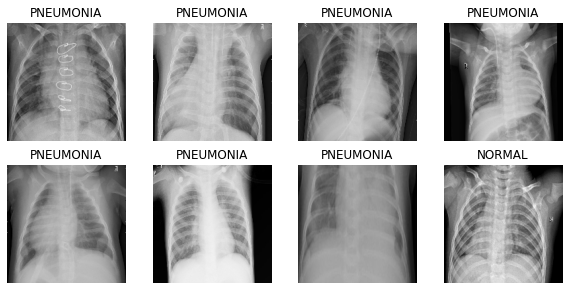

In [8]:
image_batch, label_batch = next(iter(train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(8):
        ax = plt.subplot(4,4,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch.numpy(), label_batch.numpy())

# 4. CNN Modeling
## 4.1 Modeling

In [9]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

def balance_weight():
    weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
    weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

    class_weight = {0: weight_for_0, 1: weight_for_1}

    print('Weight for class 0: {:.2f}'.format(weight_for_0))
    print('Weight for class 1: {:.2f}'.format(weight_for_1))
    return weight_for_0, weight_for_1

## 4.2 CNN model learning

In [10]:
weight_for_0, weight_for_1 = balance_weight()
class_weight = {0: weight_for_0, 1: weight_for_1}

with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Weight for class 0: 1.92
Weight for class 1: 0.68
Epoch 1/25
523/523 [==============================] - 44s 84ms/step - loss: 0.4908 - accuracy: 0.7533 - precision: 0.9260 - recall: 0.7243 - val_loss: 0.7394 - val_accuracy: 0.7548 - val_precision: 0.7548 - val_recall: 1.0000
Epoch 2/25
523/523 [==============================] - 39s 74ms/step - loss: 0.3366 - accuracy: 0.8542 - precision: 0.9579 - recall: 0.8396 - val_loss: 0.3096 - val_accuracy: 0.8519 - val_precision: 0.9984 - val_recall: 0.8043
Epoch 3/25
523/523 [==============================] - 39s 74ms/step - loss: 0.2732 - accuracy: 0.8843 - precision: 0.9688 - recall: 0.8717 - val_loss: 0.1913 - val_accuracy: 0.9308 - val_precision: 0.9931 - val_recall: 0.9146
Epoch 4/25
523/523 [==============================] - 41s 78ms/step - loss: 0.2625 - accuracy: 0.8891 - precision: 0.9653 - recall: 0.8816 - val_loss: 0.1288 - val_accuracy: 0.9442 - val_precision: 0.9764 - val_recall: 0.9490
Epoch 5/25
523/523 [==========================

## 4.3 CNN model Evaluation

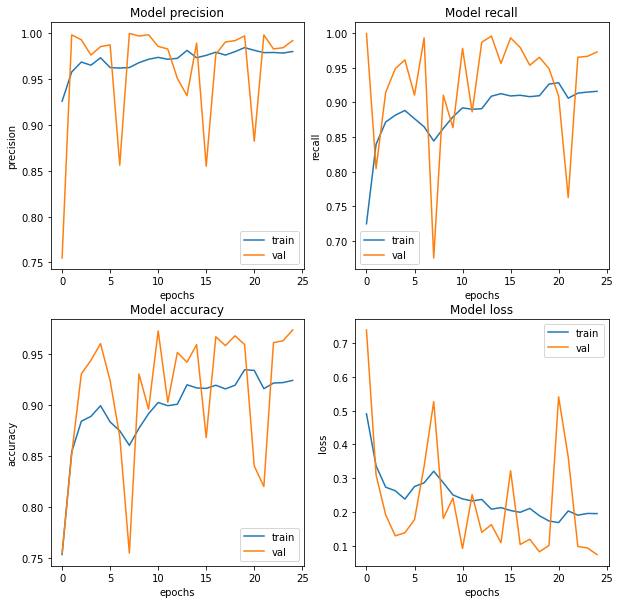

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [15]:
loss, acc, prec, rec = model.evaluate(test_ds)

78/78 [==============================] - 4s 51ms/step - loss: 0.6614 - accuracy: 0.8029 - precision: 0.7633 - recall: 0.9923
